In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.ops import rnn, rnn_cell
%matplotlib inline

Lets create a data set for our simple example. The dataset is a sequence of numbers, which represent a signwave 

In [2]:
rangeValues = np.asarray(np.arange(-2, 2.005, 0.005), dtype='f')
print rangeValues.shape

(801,)


In [3]:
allValues = np.sin(rangeValues*1.5 * np.pi)
print ('Shape of allValues',allValues.shape)
x_train = allValues[:len(allValues)-1]
print x_train.shape, x_train[0]

('Shape of allValues', (801,))
(800,) 2.38498e-08


Y will be basically the next element in the sequence of x

In [4]:
#Lets create a function to approximate 
y_train = allValues[1:]
print y_train.shape

(800,)


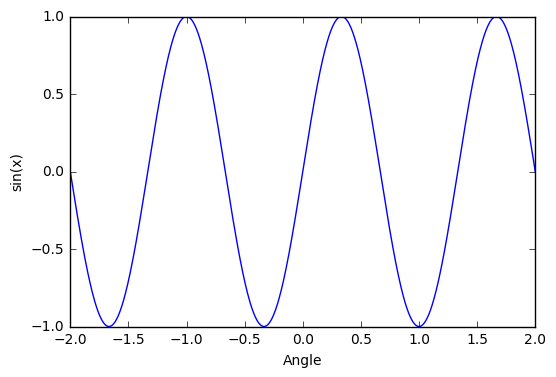

In [5]:
#PLot the function 
plt.plot(rangeValues, allValues)
plt.xlabel('Angle')
plt.ylabel('sin(x)')
plt.axis('tight')
plt.show()

In [6]:
#Parameters
d_input = 1
d_output = 1
d_hidden = 20
n_steps = 1
learning_rate = 0.001

In [7]:
#Weights and Biases defined
weights = {
    'hidden': tf.Variable(tf.random_normal([d_input, d_hidden])), 
    'out': tf.Variable(tf.random_normal([d_hidden, d_output]))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([d_hidden])),
    'out': tf.Variable(tf.random_normal([d_output]))
}

In [8]:
def rnn(_X, _istate, _W, _b, _nsteps, _name):
    
#     _X = tf.transpose(_X, [1, 0, 2])
#     _X = tf.reshape(_X, [-1, d_input])
    _H = tf.matmul(_X, _W['hidden']) + _b['hidden']
    _Hsplit = tf.split(0, _nsteps, _H) 
  
    with tf.variable_scope(_name):
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(d_hidden, forget_bias=1.0)
        _LSTM_O, _LSTM_S = tf.nn.rnn(lstm_cell, _Hsplit, initial_state=_istate)
    _O = tf.matmul(_LSTM_O[-1], _W['out']) + _b['out']    
    return {
        'X': _X, 'H': _H, 'Hsplit': _Hsplit,
        'LSTM_O': _LSTM_O, 'LSTM_S': _LSTM_S, 'O': _O 
    }
print ("Network ready")

Network ready


In [10]:
x      = tf.placeholder("float", [None, d_input])
y      = tf.placeholder("float", [None, d_output])
istate = tf.placeholder("float", [None, 2*d_hidden]) #state & cell => 2x n_hidden
myrnn  = rnn(x, istate, weights, biases, 1, 'basic')

pred   = myrnn['O']
cost   = tf.reduce_mean(tf.pow(pred-y, 2)/2) 
optm   = tf.train.AdamOptimizer(learning_rate).minimize(cost) # Adam Optimizer
#accr   = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(pred,1), tf.argmax(y,1)), tf.float32))
init   = tf.initialize_all_variables()
print ("Initalize all variable")

Initalize all variable


In [11]:
training_epochs = 300
batch_size      = 1
display_step    = 50

sess = tf.Session()
sess.run(init)

#summary_writer = tf.train.SummaryWriter('/tmp/tensorflow_logs', graph=sess.graph)
print ("Start optimization")


# Looping 
for epoch in range(training_epochs):
    for j in range(800):
        xs = x_train[j]
        ys = y_train[j]
        xs = np.reshape(xs,[1,d_input])
        ys = np.reshape(ys,[1,d_output])
        sess.run(optm, feed_dict={x: xs, y: ys, istate: np.zeros((1, 2*d_hidden))})

    # Display logs per epoch step
    if epoch % display_step == 0:
        batch_xs = np.reshape(x_train,[800,1])
        batch_ys = np.reshape(y_train,[800,1])
        costly = sess.run(cost, feed_dict={x: batch_xs, y: batch_ys, istate: np.zeros((800, 2*d_hidden))})
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, costly))

print ("Optimization Finished.")

Start optimization
Epoch: 000/300 cost: 0.570196509
Epoch: 050/300 cost: 0.018917961
Epoch: 100/300 cost: 0.012926714
Epoch: 150/300 cost: 0.008636354
Epoch: 200/300 cost: 0.008056605
Epoch: 250/300 cost: 0.007725886
Optimization Finished.


In [19]:
#infer 
fout = [0]
predict = [0]
predict = np.reshape(predict,[1,1])
print predict
for i in range(820):
    out = sess.run(pred, feed_dict={x: predict, istate: np.zeros((1, 2*d_hidden))})
    print out.shape
    temp = np.squeeze(np.asarray(out))
    fout.append(temp)
    predict = out

[[0]]
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)


(801,)
(821,)


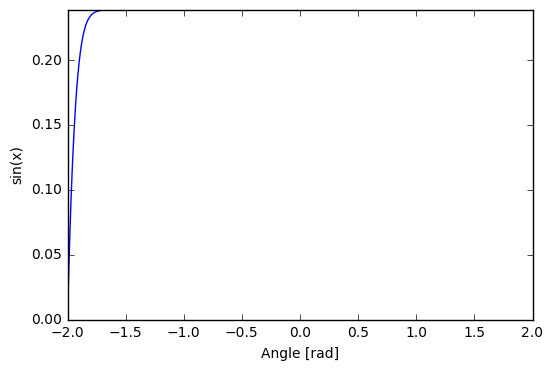

In [28]:
print rangeValues.shape
print np.asarray(fout).shape
plt.plot(rangeValues, np.asarray(fout)[:801])
plt.xlabel('Angle [rad]')
plt.ylabel('sin(x)')
plt.axis('tight')
plt.show()

In [19]:
#infer 
fout = [0]
predict = [0]
predict = np.reshape(predict,[1,1])
print predict
for i in range(1):
    out = sess.run(pred, feed_dict={x: predict, istate: np.zeros((1, 2*d_hidden))})
    temp = np.squeeze(np.asarray(out))
    fout.append(temp)
    predict = out
    


[[0]]


TypeError: Fetch argument array([[  3.40079069e-02],
       [  1.40333325e-02],
       [ -7.78540969e-03],
       [ -3.13687027e-02],
       [ -5.60844541e-02],
       [ -8.09932351e-02],
       [ -1.05245396e-01],
       [ -1.28333643e-01],
       [ -1.50122076e-01],
       [ -1.70724675e-01],
       [ -1.90369219e-01],
       [ -2.09310383e-01],
       [ -2.27776438e-01],
       [ -2.45957643e-01],
       [ -2.63998270e-01],
       [ -2.82003254e-01],
       [ -3.00041616e-01],
       [ -3.18153590e-01],
       [ -3.36353838e-01],
       [ -3.54633093e-01],
       [ -3.72966349e-01],
       [ -3.91310811e-01],
       [ -4.09613580e-01],
       [ -4.27813232e-01],
       [ -4.45840985e-01],
       [ -4.63625401e-01],
       [ -4.81097311e-01],
       [ -4.98190075e-01],
       [ -5.14841318e-01],
       [ -5.30996442e-01],
       [ -5.46610951e-01],
       [ -5.61650276e-01],
       [ -5.76088428e-01],
       [ -5.89912176e-01],
       [ -6.03115737e-01],
       [ -6.15703404e-01],
       [ -6.27686501e-01],
       [ -6.39081240e-01],
       [ -6.49907112e-01],
       [ -6.60186291e-01],
       [ -6.69942498e-01],
       [ -6.79197788e-01],
       [ -6.87974691e-01],
       [ -6.96292520e-01],
       [ -7.04171062e-01],
       [ -7.11627483e-01],
       [ -7.18676925e-01],
       [ -7.25333929e-01],
       [ -7.31610775e-01],
       [ -7.37518430e-01],
       [ -7.43066669e-01],
       [ -7.48264194e-01],
       [ -7.53117561e-01],
       [ -7.57633209e-01],
       [ -7.61815906e-01],
       [ -7.65670061e-01],
       [ -7.69199014e-01],
       [ -7.72405267e-01],
       [ -7.75291085e-01],
       [ -7.77858257e-01],
       [ -7.80108571e-01],
       [ -7.82042742e-01],
       [ -7.83661962e-01],
       [ -7.84966946e-01],
       [ -7.85958171e-01],
       [ -7.86636233e-01],
       [ -7.87001014e-01],
       [ -7.87053227e-01],
       [ -7.86792517e-01],
       [ -7.86219120e-01],
       [ -7.85332203e-01],
       [ -7.84131885e-01],
       [ -7.82617450e-01],
       [ -7.80788183e-01],
       [ -7.78643608e-01],
       [ -7.76182175e-01],
       [ -7.73402691e-01],
       [ -7.70303607e-01],
       [ -7.66882658e-01],
       [ -7.63137221e-01],
       [ -7.59064436e-01],
       [ -7.54660249e-01],
       [ -7.49919891e-01],
       [ -7.44837999e-01],
       [ -7.39407539e-01],
       [ -7.33620644e-01],
       [ -7.27467895e-01],
       [ -7.20939159e-01],
       [ -7.14022040e-01],
       [ -7.06702828e-01],
       [ -6.98966742e-01],
       [ -6.90796971e-01],
       [ -6.82175636e-01],
       [ -6.73082113e-01],
       [ -6.63495541e-01],
       [ -6.53392911e-01],
       [ -6.42751813e-01],
       [ -6.31549716e-01],
       [ -6.19764566e-01],
       [ -6.07380092e-01],
       [ -5.94382286e-01],
       [ -5.80765724e-01],
       [ -5.66531122e-01],
       [ -5.51689863e-01],
       [ -5.36263824e-01],
       [ -5.20284057e-01],
       [ -5.03792405e-01],
       [ -4.86840636e-01],
       [ -4.69488144e-01],
       [ -4.51799899e-01],
       [ -4.33845818e-01],
       [ -4.15695727e-01],
       [ -3.97419930e-01],
       [ -3.79082263e-01],
       [ -3.60740423e-01],
       [ -3.42438579e-01],
       [ -3.24210554e-01],
       [ -3.06069493e-01],
       [ -2.88009644e-01],
       [ -2.69999832e-01],
       [ -2.51980841e-01],
       [ -2.33861282e-01],
       [ -2.15508863e-01],
       [ -1.96749508e-01],
       [ -1.77366912e-01],
       [ -1.57112300e-01],
       [ -1.35739818e-01],
       [ -1.13085017e-01],
       [ -8.91841352e-02],
       [ -6.44135401e-02],
       [ -3.95263433e-02],
       [ -1.54719055e-02],
       [  6.97246194e-03],
       [  2.75369287e-02],
       [  4.64844406e-02],
       [  6.43880814e-02],
       [  8.18590224e-02],
       [  9.93828773e-02],
       [  1.17277622e-01],
       [  1.35707617e-01],
       [  1.54726446e-01],
       [  1.74311519e-01],
       [  1.94389999e-01],
       [  2.14860857e-01],
       [  2.35604644e-01],
       [  2.56493866e-01],
       [  2.77398646e-01],
       [  2.98192382e-01],
       [  3.18756670e-01],
       [  3.38981122e-01],
       [  3.58769804e-01],
       [  3.78041536e-01],
       [  3.96733493e-01],
       [  4.14799184e-01],
       [  4.32212204e-01],
       [  4.48966116e-01],
       [  4.65072602e-01],
       [  4.80560809e-01],
       [  4.95473176e-01],
       [  5.09864450e-01],
       [  5.23794055e-01],
       [  5.37322402e-01],
       [  5.50505519e-01],
       [  5.63392162e-01],
       [  5.76019883e-01],
       [  5.88415504e-01],
       [  6.00595236e-01],
       [  6.12564087e-01],
       [  6.24318838e-01],
       [  6.35848880e-01],
       [  6.47135615e-01],
       [  6.58156753e-01],
       [  6.68885827e-01],
       [  6.79294348e-01],
       [  6.89353228e-01],
       [  6.99033380e-01],
       [  7.08309889e-01],
       [  7.17159390e-01],
       [  7.25563884e-01],
       [  7.33509898e-01],
       [  7.40988612e-01],
       [  7.47997046e-01],
       [  7.54535794e-01],
       [  7.60609865e-01],
       [  7.66227961e-01],
       [  7.71401525e-01],
       [  7.76143789e-01],
       [  7.80469656e-01],
       [  7.84395218e-01],
       [  7.87935972e-01],
       [  7.91108131e-01],
       [  7.93927073e-01],
       [  7.96407461e-01],
       [  7.98562527e-01],
       [  8.00404906e-01],
       [  8.01944852e-01],
       [  8.03192019e-01],
       [  8.04154158e-01],
       [  8.04836869e-01],
       [  8.05244803e-01],
       [  8.05380583e-01],
       [  8.05244803e-01],
       [  8.04836869e-01],
       [  8.04154158e-01],
       [  8.03192019e-01],
       [  8.01944971e-01],
       [  8.00404906e-01],
       [  7.98562527e-01],
       [  7.96407461e-01],
       [  7.93927073e-01],
       [  7.91108131e-01],
       [  7.87935972e-01],
       [  7.84395099e-01],
       [  7.80469894e-01],
       [  7.76143789e-01],
       [  7.71401644e-01],
       [  7.66228199e-01],
       [  7.60610104e-01],
       [  7.54535913e-01],
       [  7.47997046e-01],
       [  7.40988851e-01],
       [  7.33509898e-01],
       [  7.25564122e-01],
       [  7.17159510e-01],
       [  7.08309889e-01],
       [  6.99033499e-01],
       [  6.89353228e-01],
       [  6.79294586e-01],
       [  6.68886065e-01],
       [  6.58156753e-01],
       [  6.47135615e-01],
       [  6.35848880e-01],
       [  6.24319077e-01],
       [  6.12563968e-01],
       [  6.00595236e-01],
       [  5.88415504e-01],
       [  5.76019883e-01],
       [  5.63392162e-01],
       [  5.50505877e-01],
       [  5.37322760e-01],
       [  5.23794532e-01],
       [  5.09864688e-01],
       [  4.95473653e-01],
       [  4.80560809e-01],
       [  4.65073019e-01],
       [  4.48966295e-01],
       [  4.32212502e-01],
       [  4.14799362e-01],
       [  3.96733493e-01],
       [  3.78041834e-01],
       [  3.58769804e-01],
       [  3.38981360e-01],
       [  3.18756908e-01],
       [  2.98192859e-01],
       [  2.77398854e-01],
       [  2.56494284e-01],
       [  2.35604912e-01],
       [  2.14861065e-01],
       [  1.94389999e-01],
       [  1.74311340e-01],
       [  1.54726446e-01],
       [  1.35707796e-01],
       [  1.17277682e-01],
       [  9.93834436e-02],
       [  8.18592012e-02],
       [  6.43888265e-02],
       [  4.64850366e-02],
       [  2.75373608e-02],
       [  6.97268546e-03],
       [ -1.54721290e-02],
       [ -3.95255089e-02],
       [ -6.44132271e-02],
       [ -8.91838223e-02],
       [ -1.13084286e-01],
       [ -1.35739520e-01],
       [ -1.57112002e-01],
       [ -1.77367091e-01],
       [ -1.96749508e-01],
       [ -2.15508461e-01],
       [ -2.33860910e-01],
       [ -2.51980841e-01],
       [ -2.69999474e-01],
       [ -2.88009435e-01],
       [ -3.06069583e-01],
       [ -3.24210554e-01],
       [ -3.42439085e-01],
       [ -3.60740036e-01],
       [ -3.79082382e-01],
       [ -3.97419602e-01],
       [ -4.15695369e-01],
       [ -4.33844864e-01],
       [ -4.51799542e-01],
       [ -4.69487667e-01],
       [ -4.86840636e-01],
       [ -5.03792524e-01],
       [ -5.20283818e-01],
       [ -5.36263466e-01],
       [ -5.51689863e-01],
       [ -5.66530824e-01],
       [ -5.80765367e-01],
       [ -5.94382286e-01],
       [ -6.07380092e-01],
       [ -6.19764686e-01],
       [ -6.31549358e-01],
       [ -6.42751813e-01],
       [ -6.53392911e-01],
       [ -6.63495421e-01],
       [ -6.73082113e-01],
       [ -6.82175517e-01],
       [ -6.90797091e-01],
       [ -6.98966980e-01],
       [ -7.06702828e-01],
       [ -7.14022040e-01],
       [ -7.20939040e-01],
       [ -7.27467895e-01],
       [ -7.33620405e-01],
       [ -7.39407301e-01],
       [ -7.44837880e-01],
       [ -7.49919891e-01],
       [ -7.54660249e-01],
       [ -7.59064436e-01],
       [ -7.63137221e-01],
       [ -7.66882539e-01],
       [ -7.70303488e-01],
       [ -7.73402691e-01],
       [ -7.76182175e-01],
       [ -7.78643608e-01],
       [ -7.80788183e-01],
       [ -7.82617450e-01],
       [ -7.84131885e-01],
       [ -7.85332203e-01],
       [ -7.86219001e-01],
       [ -7.86792517e-01],
       [ -7.87053227e-01],
       [ -7.87001014e-01],
       [ -7.86636233e-01],
       [ -7.85958171e-01],
       [ -7.84966946e-01],
       [ -7.83661962e-01],
       [ -7.82042861e-01],
       [ -7.80108571e-01],
       [ -7.77858377e-01],
       [ -7.75291085e-01],
       [ -7.72405267e-01],
       [ -7.69199133e-01],
       [ -7.65670180e-01],
       [ -7.61816144e-01],
       [ -7.57633209e-01],
       [ -7.53117681e-01],
       [ -7.48264194e-01],
       [ -7.43066669e-01],
       [ -7.37518430e-01],
       [ -7.31610656e-01],
       [ -7.25333929e-01],
       [ -7.18677163e-01],
       [ -7.11627603e-01],
       [ -7.04171300e-01],
       [ -6.96292758e-01],
       [ -6.87974453e-01],
       [ -6.79197848e-01],
       [ -6.69942439e-01],
       [ -6.60186350e-01],
       [ -6.49906874e-01],
       [ -6.39081240e-01],
       [ -6.27686858e-01],
       [ -6.15703881e-01],
       [ -6.03116155e-01],
       [ -5.89912295e-01],
       [ -5.76088786e-01],
       [ -5.61650395e-01],
       [ -5.46611428e-01],
       [ -5.30996621e-01],
       [ -5.14841199e-01],
       [ -4.98190284e-01],
       [ -4.81097788e-01],
       [ -4.63625729e-01],
       [ -4.45840716e-01],
       [ -4.27813500e-01],
       [ -4.09614205e-01],
       [ -3.91311049e-01],
       [ -3.72966290e-01],
       [ -3.54633391e-01],
       [ -3.36353749e-01],
       [ -3.18153858e-01],
       [ -3.00041437e-01],
       [ -2.82002866e-01],
       [ -2.63998210e-01],
       [ -2.45957911e-01],
       [ -2.27777094e-01],
       [ -2.09310740e-01],
       [ -1.90369993e-01],
       [ -1.70725018e-01],
       [ -1.50122851e-01],
       [ -1.28334090e-01],
       [ -1.05245352e-01],
       [ -8.09937045e-02],
       [ -5.60844541e-02],
       [ -3.13691795e-02],
       [ -7.78630376e-03],
       [  1.40329152e-02],
       [  3.40078920e-02],
       [  5.25372773e-02],
       [  7.02327788e-02],
       [  8.76753926e-02],
       [  1.05296046e-01],
       [  1.23356968e-01],
       [  1.41981781e-01],
       [  1.61194652e-01],
       [  1.80953860e-01],
       [  2.01175719e-01],
       [  2.21751302e-01],
       [  2.42558062e-01],
       [  2.63466805e-01],
       [  2.84348488e-01],
       [  3.05078715e-01],
       [  3.25540930e-01],
       [  3.45630139e-01],
       [  3.65254909e-01],
       [  3.84339541e-01],
       [  4.02826816e-01],
       [  4.20676857e-01],
       [  4.37870234e-01],
       [  4.54406112e-01],
       [  4.70302314e-01],
       [  4.85593110e-01],
       [  5.00325441e-01],
       [  5.14556050e-01],
       [  5.28345466e-01],
       [  5.41752815e-01],
       [  5.54832220e-01],
       [  5.67628503e-01],
       [  5.80176473e-01],
       [  5.92498899e-01],
       [  6.04608178e-01],
       [  6.16506577e-01],
       [  6.28188014e-01],
       [  6.39639020e-01],
       [  6.50840163e-01],
       [  6.61767006e-01],
       [  6.72392368e-01],
       [  6.82687640e-01],
       [  6.92623258e-01],
       [  7.02171564e-01],
       [  7.11308122e-01],
       [  7.20011115e-01],
       [  7.28264093e-01],
       [  7.36055255e-01],
       [  7.43377209e-01],
       [  7.50228643e-01],
       [  7.56611943e-01],
       [  7.62532830e-01],
       [  7.68001437e-01],
       [  7.73029447e-01],
       [  7.77631283e-01],
       [  7.81821966e-01],
       [  7.85617232e-01],
       [  7.89033532e-01],
       [  7.92086363e-01],
       [  7.94790745e-01],
       [  7.97161341e-01],
       [  7.99210906e-01],
       [  8.00951242e-01],
       [  8.02392721e-01],
       [  8.03544164e-01],
       [  8.04412484e-01],
       [  8.05003285e-01],
       [  8.05320382e-01],
       [  8.05365562e-01],
       [  8.05139303e-01],
       [  8.04640055e-01],
       [  8.03864598e-01],
       [  8.02808404e-01],
       [  8.01464438e-01],
       [  7.99824715e-01],
       [  7.97879457e-01],
       [  7.95617342e-01],
       [  7.93025732e-01],
       [  7.90090799e-01],
       [  7.86797404e-01],
       [  7.83130169e-01],
       [  7.79073119e-01],
       [  7.74610043e-01],
       [  7.69725680e-01],
       [  7.64405370e-01],
       [  7.58636236e-01],
       [  7.52408266e-01],
       [  7.45713353e-01],
       [  7.38548040e-01],
       [  7.30912805e-01],
       [  7.22812772e-01],
       [  7.14258075e-01],
       [  7.05264211e-01],
       [  6.95850253e-01],
       [  6.86040759e-01],
       [  6.75862312e-01],
       [  6.65343761e-01],
       [  6.54514074e-01],
       [  6.43401384e-01],
       [  6.32031322e-01],
       [  6.20424867e-01],
       [  6.08597755e-01],
       [  5.96558690e-01],
       [  5.84308147e-01],
       [  5.71837544e-01],
       [  5.59126973e-01],
       [  5.46146512e-01],
       [  5.32854199e-01],
       [  5.19198656e-01],
       [  5.05121708e-01],
       [  4.90563184e-01],
       [  4.75464016e-01],
       [  4.59774405e-01],
       [  4.43454593e-01],
       [  4.26481456e-01],
       [  4.08848673e-01],
       [  3.90570790e-01],
       [  3.71679515e-01],
       [  3.52227360e-01],
       [  3.32283646e-01],
       [  3.11934441e-01],
       [  2.91281134e-01],
       [  2.70436436e-01],
       [  2.49522537e-01],
       [  2.28667408e-01],
       [  2.08000869e-01],
       [  1.87648028e-01],
       [  1.67723745e-01],
       [  1.48321658e-01],
       [  1.29499644e-01],
       [  1.11258835e-01],
       [  9.35128927e-02],
       [  7.60502219e-02],
       [  5.84973693e-02],
       [  4.03161049e-02],
       [  2.08839774e-02],
       [ -3.01584601e-04],
       [ -2.33414471e-02],
       [ -4.77763116e-02],
       [ -7.27272034e-02],
       [ -9.72741693e-02],
       [ -1.20781988e-01],
       [ -1.43001050e-01],
       [ -1.63976461e-01],
       [ -1.83912367e-01],
       [ -2.03060597e-01],
       [ -2.21662149e-01],
       [ -2.39919707e-01],
       [ -2.57993132e-01],
       [ -2.76000470e-01],
       [ -2.94021994e-01],
       [ -3.12106848e-01],
       [ -3.30277264e-01],
       [ -3.48532557e-01],
       [ -3.66851866e-01],
       [ -3.85197937e-01],
       [ -4.03521299e-01],
       [ -4.21762705e-01],
       [ -4.39855158e-01],
       [ -4.57728952e-01],
       [ -4.75312918e-01],
       [ -4.92539138e-01],
       [ -5.09343386e-01],
       [ -5.25669575e-01],
       [ -5.41468859e-01],
       [ -5.56703210e-01],
       [ -5.71343780e-01],
       [ -5.85373342e-01],
       [ -5.98783612e-01],
       [ -6.11575961e-01],
       [ -6.23758912e-01],
       [ -6.35347366e-01],
       [ -6.46360159e-01],
       [ -6.56819224e-01],
       [ -6.66747153e-01],
       [ -6.76167071e-01],
       [ -6.85100913e-01],
       [ -6.93569660e-01],
       [ -7.01592922e-01],
       [ -7.09188104e-01],
       [ -7.16371536e-01],
       [ -7.23157763e-01],
       [ -7.29559898e-01],
       [ -7.35589623e-01],
       [ -7.41256952e-01],
       [ -7.46570349e-01],
       [ -7.51537800e-01],
       [ -7.56165504e-01],
       [ -7.60458708e-01],
       [ -7.64421821e-01],
       [ -7.68058777e-01],
       [ -7.71372080e-01],
       [ -7.74364591e-01],
       [ -7.77037978e-01],
       [ -7.79393673e-01],
       [ -7.81433225e-01],
       [ -7.83157110e-01],
       [ -7.84566760e-01],
       [ -7.85662651e-01],
       [ -7.86444902e-01],
       [ -7.86914110e-01],
       [ -7.87070632e-01],
       [ -7.86914110e-01],
       [ -7.86444902e-01],
       [ -7.85662651e-01],
       [ -7.84566760e-01],
       [ -7.83157110e-01],
       [ -7.81433225e-01],
       [ -7.79393554e-01],
       [ -7.77037978e-01],
       [ -7.74364710e-01],
       [ -7.71372080e-01],
       [ -7.68058896e-01],
       [ -7.64421940e-01],
       [ -7.60458589e-01],
       [ -7.56165504e-01],
       [ -7.51537681e-01],
       [ -7.46570110e-01],
       [ -7.41256714e-01],
       [ -7.35589385e-01],
       [ -7.29559898e-01],
       [ -7.23157644e-01],
       [ -7.16371536e-01],
       [ -7.09187984e-01],
       [ -7.01592803e-01],
       [ -6.93569660e-01],
       [ -6.85100675e-01],
       [ -6.76167071e-01],
       [ -6.66746914e-01],
       [ -6.56818986e-01],
       [ -6.46359980e-01],
       [ -6.35347366e-01],
       [ -6.23758912e-01],
       [ -6.11575723e-01],
       [ -5.98783672e-01],
       [ -5.85373342e-01],
       [ -5.71343899e-01],
       [ -5.56703210e-01],
       [ -5.41468978e-01],
       [ -5.25669217e-01],
       [ -5.09343147e-01],
       [ -4.92538631e-01],
       [ -4.75312442e-01],
       [ -4.57728416e-01],
       [ -4.39855158e-01],
       [ -4.21762377e-01],
       [ -4.03521180e-01],
       [ -3.85197520e-01],
       [ -3.66851687e-01],
       [ -3.48532498e-01],
       [ -3.30277056e-01],
       [ -3.12106848e-01],
       [ -2.94021785e-01],
       [ -2.76000261e-01],
       [ -2.57992744e-01],
       [ -2.39919484e-01],
       [ -2.21661776e-01],
       [ -2.03060374e-01],
       [ -1.83912128e-01],
       [ -1.63976431e-01],
       [ -1.43001288e-01],
       [ -1.20781973e-01],
       [ -9.72739011e-02],
       [ -7.27271959e-02],
       [ -4.77755368e-02],
       [ -2.33411491e-02],
       [ -3.00705433e-04],
       [  2.08846778e-02],
       [  4.03164923e-02],
       [  5.84975779e-02],
       [  7.60500729e-02],
       [  9.35134888e-02],
       [  1.11259043e-01],
       [  1.29499853e-01],
       [  1.48322254e-01],
       [  1.67724013e-01],
       [  1.87648267e-01],
       [  2.08000630e-01],
       [  2.28667408e-01],
       [  2.49522924e-01],
       [  2.70436883e-01],
       [  2.91281134e-01],
       [  3.11934918e-01],
       [  3.32283825e-01],
       [  3.52227181e-01],
       [  3.71679574e-01],
       [  3.90570253e-01],
       [  4.08849150e-01],
       [  4.26481336e-01],
       [  4.43455011e-01],
       [  4.59774703e-01],
       [  4.75464910e-01],
       [  4.90563422e-01],
       [  5.05122066e-01],
       [  5.19198656e-01],
       [  5.32854080e-01],
       [  5.46146870e-01],
       [  5.59127331e-01],
       [  5.71837544e-01],
       [  5.84308505e-01],
       [  5.96558809e-01],
       [  6.08597755e-01],
       [  6.20424867e-01],
       [  6.32031202e-01],
       [  6.43401742e-01],
       [  6.54514194e-01],
       [  6.65343761e-01],
       [  6.75862551e-01],
       [  6.86040759e-01],
       [  6.95850372e-01],
       [  7.05264091e-01],
       [  7.14257956e-01],
       [  7.22812891e-01],
       [  7.30912805e-01],
       [  7.38548398e-01],
       [  7.45713353e-01],
       [  7.52408504e-01],
       [  7.58636594e-01],
       [  7.64405489e-01],
       [  7.69725800e-01],
       [  7.74610043e-01],
       [  7.79073238e-01],
       [  7.83130169e-01],
       [  7.86797404e-01],
       [  7.90090799e-01],
       [  7.93025851e-01],
       [  7.95617461e-01],
       [  7.97879457e-01],
       [  7.99824715e-01],
       [  8.01464438e-01],
       [  8.02808404e-01],
       [  8.03864598e-01],
       [  8.04640055e-01],
       [  8.05139303e-01],
       [  8.05365562e-01],
       [  8.05320382e-01],
       [  8.05003285e-01],
       [  8.04412484e-01],
       [  8.03544164e-01],
       [  8.02392721e-01],
       [  8.00951242e-01],
       [  7.99210787e-01],
       [  7.97161222e-01],
       [  7.94790745e-01],
       [  7.92086363e-01],
       [  7.89033413e-01],
       [  7.85617113e-01],
       [  7.81821966e-01],
       [  7.77631283e-01],
       [  7.73029447e-01],
       [  7.68001437e-01],
       [  7.62532711e-01],
       [  7.56611824e-01],
       [  7.50228763e-01],
       [  7.43377209e-01],
       [  7.36054897e-01],
       [  7.28263974e-01],
       [  7.20010996e-01],
       [  7.11308002e-01],
       [  7.02171803e-01],
       [  6.92623258e-01],
       [  6.82687759e-01],
       [  6.72392368e-01],
       [  6.61767125e-01],
       [  6.50840044e-01],
       [  6.39638662e-01],
       [  6.28187418e-01],
       [  6.16506219e-01],
       [  6.04608059e-01],
       [  5.92498541e-01],
       [  5.80176473e-01],
       [  5.67628145e-01],
       [  5.54831982e-01],
       [  5.41752934e-01],
       [  5.28345227e-01],
       [  5.14555693e-01],
       [  5.00325322e-01],
       [  4.85593170e-01],
       [  4.70302075e-01],
       [  4.54405636e-01],
       [  4.37870115e-01],
       [  4.20676857e-01],
       [  4.02826458e-01],
       [  3.84339720e-01],
       [  3.65254551e-01],
       [  3.45630199e-01],
       [  3.25541526e-01],
       [  3.05078834e-01],
       [  2.84348190e-01],
       [  2.63466001e-01],
       [  2.42557704e-01],
       [  2.21750587e-01],
       [  2.01175392e-01],
       [  1.80953115e-01],
       [  1.61194265e-01],
       [  1.41981781e-01],
       [  1.23356640e-01],
       [  1.05296046e-01],
       [  8.76750350e-02],
       [  7.02321231e-02],
       [  5.25369346e-02]], dtype=float32) has invalid type <type 'numpy.ndarray'>, must be a string or Tensor. (Can not convert a ndarray into a Tensor or Operation.)

In [13]:
fopt = np.squeeze(np.asarray(pred))
print fopt.shape

(800,)


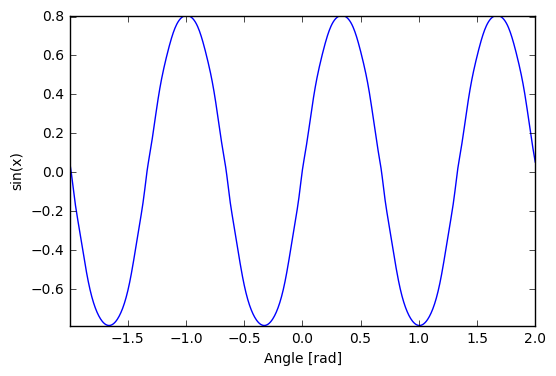

In [15]:
plt.plot(rangeValues[1:], fopt)
plt.xlabel('Angle [rad]')
plt.ylabel('sin(x)')
plt.axis('tight')
plt.show()

In [9]:
x      = tf.placeholder("float", [None, d_input])
y      = tf.placeholder("float", [None, d_output])
istate = tf.placeholder("float", [None, 2*d_hidden]) #state & cell => 2x n_hidden
myrnn  = rnn(x, istate, weights, biases, 1, 'basic')

pred   = myrnn['O']
cost   = tf.reduce_mean(tf.pow(pred-y, 2)/2) 
optm   = tf.train.AdamOptimizer(learning_rate).minimize(cost) # Adam Optimizer
#accr   = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(pred,1), tf.argmax(y,1)), tf.float32))
init   = tf.initialize_all_variables()
print ("Initalize all variable")

Initalize all variable


In [8]:
def _RNN(_X, _istate, _W, _b, _nsteps, _name):
    
#     _X = tf.transpose(_X, [1, 0, 2])
#     _X = tf.reshape(_X, [-1, d_input])
    _H = tf.matmul(_X, _W['hidden']) + _b['hidden']
    _Hsplit = tf.split(0, _nsteps, _H) 
  
    with tf.variable_scope(_name):
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(d_hidden, forget_bias=1.0)
        _LSTM_O, _LSTM_S = tf.nn.rnn(lstm_cell, _Hsplit, initial_state=_istate)
    _O = tf.matmul(_LSTM_O[:], _W['out']) + _b['out']    
    return {
        'X': _X, 'H': _H, 'Hsplit': _Hsplit,
        'LSTM_O': _LSTM_O, 'LSTM_S': _LSTM_S, 'O': _O 
    }
print ("Network ready")

Network ready


In [9]:
x      = tf.placeholder("float", [None, n_steps, d_input])
y      = tf.placeholder("float", [None, d_output])
istate = tf.placeholder("float", [None, 2*d_hidden]) #state & cell => 2x n_hidden
myrnn  = _RNN(x, istate, weights, biases, n_steps, 'basic')

pred   = myrnn['O']
cost   = tf.reduce_mean(tf.pow(pred-y, 2)) 
optm   = tf.train.AdamOptimizer(learning_rate).minimize(cost) # Adam Optimizer
accr   = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(pred,1), tf.argmax(y,1)), tf.float32))
init   = tf.initialize_all_variables()
print ("Initalize all variable")

ValueError: Shape (200, ?, 20) must have rank 2

In [ ]:
training_epochs = 300
batch_size      = 200
display_step    = 50

sess = tf.Session()
sess.run(init)

#summary_writer = tf.train.SummaryWriter('/tmp/tensorflow_logs', graph=sess.graph)
print ("Start optimization")

for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(x_train.shape[0]/batch_size)
    # Loop over all batches
    for i in range(4):
        batch_xs = x_train[i*batch_size*n_steps:(i+1)*batch_size*n_steps]
        batch_ys = y_train[i*batch_size*n_steps:(i+1)*batch_size*n_steps]
        batch_ys =np.matrix(np.reshape(batch_ys,[200,1]))
    
        batch_xs = np.reshape(batch_xs,[batch_size, n_steps, d_input])

        # Fit training using batch data
        sess.run(optm, feed_dict={x: batch_xs, y: batch_ys, istate: np.zeros((batch_size, 2*d_hidden))})
        # Compute average loss
        avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys 
                                              , istate: np.zeros((batch_size, 2*d_hidden))})/4
    # Display logs per epoch step
    if epoch % display_step == 0: 
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_cost))
        train_acc = sess.run(accr, feed_dict={x: batch_xs, y: batch_ys, istate: np.zeros((batch_size, 2*d_hidden))})
        print (" Training accuracy: %.3f" % (train_acc))
#         testimgs = testimgs.reshape((ntest, nsteps, diminput))
#         test_acc = sess.run(accr, feed_dict={x: testimgs, y: testlabels, istate: np.zeros((ntest, 2*d_hidden))})
#         print (" Test accuracy: %.3f" % (test_acc))
print ("Optimization Finished.")

In [11]:
x_test = x_train[:200] # Lets see how well it fits

x_test = np.reshape(x_test,[1,200,1])
myrnn  = sess.run(myrnn, feed_dict={x: x_test, istate: np.zeros((1, 2*d_hidden))})
print myrnn['O']

[[-0.21469682]]


In [10]:
print np.asarray(myrnn['LSTM_O']).shape
print myrnn['LSTM_O'][:].shape


NameError: name 'myrnn' is not defined